In [1]:
import sys, os, gc
import subprocess
from math import *
import numpy as np
from datetime import *
from pylab import *
import random
from datetime import datetime
import json
import imgaug as ia
import imgaug.augmenters as iaa
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical

In [2]:
def vgg6(input_shape=(128, 128, 3)):


    model = tf.keras.models.Sequential(name='VGG6')

    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', name='conv2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', name='conv3'))
    model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', name='conv4'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.25))
    
    model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', name='conv5'))
    model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu', name='conv6'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_3'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))

    ## Fully connected layers
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(256, activation='relu', name='fc_2'))

       
    model.add(tf.keras.layers.Dense(128, activation='relu', name='fc_3'))
    
    model.add(tf.keras.layers.Dense(64, activation='relu', name='fc_4'))

    model.add(tf.keras.layers.Dense(8, activation='relu', name='fc_5'))
    # output layer
    model.add(tf.keras.layers.Dense(2, activation='softmax'))

    return model

def esn_shuffle(array, seed=0):
        np.random.seed(seed)
        np.random.shuffle(array)
        return array

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)


In [3]:
model = vgg6()
model.summary()

Model: "VGG6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 126, 126, 128)     3584      
_________________________________________________________________
conv2 (Conv2D)               (None, 124, 124, 128)     147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 128)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 60, 60, 256)       295168    
_________________________________________________________________
conv4 (Conv2D)               (None, 58, 58, 256)       590080    
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 58, 58, 256)       1024   

In [4]:
def esn_shuffle(array, seed=None):
        if seed is not None:
            np.random.seed(seed)
        np.random.shuffle(array)
        return array

In [5]:
seq = iaa.Sequential([
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.1))),
    iaa.GammaContrast(gamma=(0.97,1.03)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 3), per_channel=0.5),
    iaa.Add((-5, 5), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.5),
    iaa.Sometimes(0.1, iaa.Grayscale(alpha=(0.0, 1.0))),
    iaa.Sometimes(0.50, iaa.Grayscale(alpha=1.)),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(
        rotate=(0, 359),
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}, 
        mode=ia.ALL, cval=(0, 255))
    ], random_order=True)


seqGray = iaa.Sequential([
    iaa.GammaContrast(gamma=(0.97,1.03)),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(
        rotate=(0, 359),
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}, 
        mode=ia.ALL, cval=(255, 255))
    ], random_order=True)

In [6]:
%%time 

data = np.load('samples_binary/RGB_128x128_test_000.npz')
images_RGB = data['images'].astype(np.uint8)
labels_RGB = data['labels'] 
pgcIDs_RGB = data['pgcIDs']
N = images_RGB.shape[0]
filter_RGB = np.chararray(N)
filter_RGB[:] = 'c'
data.close() 
del data


data = np.load('samples_binary/g_128x128_test_000.npz')
images_g = data['images'].astype(np.uint8)
labels_g = data['labels'] 
pgcIDs_g = data['pgcIDs']
N = images_g.shape[0]
filter_g = np.chararray(N)
filter_g[:] = 'g'
data.close() 
del data

data = np.load('samples_binary/r_128x128_test_000.npz')
images_r = data['images'].astype(np.uint8)
labels_r = data['labels'] 
pgcIDs_r = data['pgcIDs']
N = images_r.shape[0]
filter_r = np.chararray(N)
filter_r[:] = 'r'
data.close() 
del data

data = np.load('samples_binary/i_128x128_test_000.npz')
images_i = data['images'].astype(np.uint8)
labels_i = data['labels'] 
pgcIDs_i = data['pgcIDs']
N = images_i.shape[0]
filter_i = np.chararray(N)
filter_i[:] = 'i'
data.close() 
del data

CPU times: user 2.93 s, sys: 126 ms, total: 3.05 s
Wall time: 3.16 s


In [7]:
images_gri = np.concatenate((images_g, images_r, images_i))
labels_gri = np.concatenate((labels_g, labels_r, labels_i))
pgcIDs_gri = np.concatenate((pgcIDs_g, pgcIDs_r, pgcIDs_i))
filter_gri = np.concatenate((filter_g, filter_r, filter_i))

N_RGB = len(labels_RGB)
N_gri = len(labels_gri)

In [8]:
ia.seed(100)

indx = esn_shuffle(np.arange(N_gri), seed=200)
images_aug = seqGray(images=images_gri[indx][:N_RGB,:,:,:])
labels_aug = labels_gri[indx][:N_RGB]
pgcIDs_aug = pgcIDs_gri[indx][:N_RGB]
filter_aug = filter_gri[indx][:N_RGB]

n = len(images_aug)
p = int(n/2)
images_aug[:p] = 255 - images_aug[:p]

ia.seed(200)

images_aug = np.concatenate((seq(images=images_RGB),images_aug))
labels_aug = np.concatenate((labels_RGB,labels_aug))
pgcIDs_aug = np.concatenate((pgcIDs_RGB,pgcIDs_aug))
filter_aug = np.concatenate((filter_RGB,filter_aug))

indx = np.arange(len(images_aug))
indx = esn_shuffle(indx, seed=100)
images_test_aug = images_aug[indx]
labels_test_aug = labels_aug[indx]
pgcIDs_test_aug = pgcIDs_aug[indx]
filter_test_aug = filter_aug[indx]



In [9]:
len(labels_test_aug[(labels_test_aug==1)])

1201

(array([3369.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1201.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

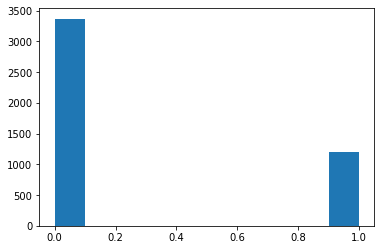

In [10]:
plt.hist(labels_test_aug)

In [11]:
batches = esn_shuffle(np.arange(50), seed=20)

for i in range(1,60):
    batches = np.concatenate((batches, esn_shuffle(np.arange(50), seed=i*20))) 

batches, len(batches)

(array([12, 14,  4, ..., 14, 15, 45]), 3000)

In [12]:
zp_dir = 'Uset0_binary_npz/'
ckpt_dir = 'U0_model05_binary_ckpt/'

def trainer(iter, batches, suffix=None):

  if suffix is None:
    suffix = ''

  batchNo = batches[iter]
  if True: 

    vgg_model = vgg6()
    vgg_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    if iter>0:

      vgg_model = vgg6()
      vgg_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
      vgg_model.load_weights(ckpt_dir+str(iter-1)+suffix+".ckpt")

      # if batchNo % 2 == 0 : 
      #   for layer in vgg_model.layers[:-1]:
      #     layer.trainable = False

      with open(ckpt_dir+'evalDict'+suffix+'.json') as json_file:
        evalDict = json.load(json_file)
    else:
      evalDict = {}


    print(iter, batchNo)


    batchFile = npzname = '128x128_train_aug_'+'%02d'%(batchNo+1)+'.npz'
    data = np.load(zp_dir + batchFile)
    images_train_aug = data['images'].astype(np.uint8)
    labels_train_aug = data['labels']
    pgcIDs_train_aug = data['pgcIDs']
    data.close() 
    del data

    
    n_epochs=1
    vgg_model.fit(images_train_aug, labels_train_aug, 
                                      epochs=n_epochs, batch_size=64, 
                                      validation_data=(images_test_aug, labels_test_aug),
                                      verbose=1, shuffle=True)
    evalDict[iter] = {} 
    for key in vgg_model.history.history:
      evalDict[iter][key] = vgg_model.history.history[key][0]
    evalDict[iter]["batchNo"] = batchNo
    evalDict[iter]["batchFile"] = batchFile
    
    with open(ckpt_dir+"evalDict"+suffix+".json", "w", encoding ='utf8') as outfile:
      json.dump(evalDict, outfile, allow_nan=True, cls=NpEncoder)
    
    vgg_model.save_weights(ckpt_dir+str(iter)+suffix+".ckpt")

    del vgg_model
    tf.keras.backend.clear_session()
    del images_train_aug 
    del labels_train_aug
    del pgcIDs_train_aug

    gc.collect()

    return evalDict

In [13]:
with tf.device('/gpu:0'):
    for i in range(0,1000):
        trainer(i, batches)

0 12
313/313 [==============================] - 167s 535ms/step - loss: 0.6243 - accuracy: 0.6439 - val_loss: 0.8494 - val_accuracy: 0.4088
1 14
313/313 [==============================] - 91s 292ms/step - loss: 0.5712 - accuracy: 0.6827 - val_loss: 0.5204 - val_accuracy: 0.6431
2 4
313/313 [==============================] - 91s 292ms/step - loss: 0.5350 - accuracy: 0.7071 - val_loss: 0.5818 - val_accuracy: 0.6186
3 8
313/313 [==============================] - 91s 292ms/step - loss: 0.5019 - accuracy: 0.7268 - val_loss: 0.4925 - val_accuracy: 0.6796
4 45
313/313 [==============================] - 91s 291ms/step - loss: 0.4871 - accuracy: 0.7379 - val_loss: 0.5224 - val_accuracy: 0.6538
5 1
313/313 [==============================] - 91s 291ms/step - loss: 0.4732 - accuracy: 0.7618 - val_loss: 0.4545 - val_accuracy: 0.7676
6 25
313/313 [==============================] - 91s 291ms/step - loss: 0.4572 - accuracy: 0.7796 - val_loss: 0.5913 - val_accuracy: 0.6663
7 24
313/313 [===============

59 23
313/313 [==============================] - 91s 290ms/step - loss: 0.2966 - accuracy: 0.8737 - val_loss: 0.3371 - val_accuracy: 0.8455
60 40
313/313 [==============================] - 91s 291ms/step - loss: 0.3018 - accuracy: 0.8699 - val_loss: 0.3599 - val_accuracy: 0.8492
61 17
313/313 [==============================] - 91s 291ms/step - loss: 0.2939 - accuracy: 0.8745 - val_loss: 0.3189 - val_accuracy: 0.8582
62 18
313/313 [==============================] - 91s 291ms/step - loss: 0.2923 - accuracy: 0.8771 - val_loss: 0.3639 - val_accuracy: 0.8333
63 0
313/313 [==============================] - 91s 290ms/step - loss: 0.2873 - accuracy: 0.8796 - val_loss: 0.3597 - val_accuracy: 0.8462
64 27
313/313 [==============================] - 91s 291ms/step - loss: 0.2937 - accuracy: 0.8763 - val_loss: 0.2764 - val_accuracy: 0.8770
65 33
313/313 [==============================] - 91s 290ms/step - loss: 0.2896 - accuracy: 0.8780 - val_loss: 0.5238 - val_accuracy: 0.7554
66 36
313/313 [======

313/313 [==============================] - 91s 291ms/step - loss: 0.2569 - accuracy: 0.8923 - val_loss: 0.2806 - val_accuracy: 0.8829
118 5
313/313 [==============================] - 91s 291ms/step - loss: 0.2569 - accuracy: 0.8943 - val_loss: 0.2765 - val_accuracy: 0.8810
119 13
313/313 [==============================] - 91s 290ms/step - loss: 0.2599 - accuracy: 0.8906 - val_loss: 0.2779 - val_accuracy: 0.8761
120 39
313/313 [==============================] - 91s 291ms/step - loss: 0.2518 - accuracy: 0.8945 - val_loss: 0.3093 - val_accuracy: 0.8742
121 17
313/313 [==============================] - 91s 290ms/step - loss: 0.2568 - accuracy: 0.8943 - val_loss: 0.2808 - val_accuracy: 0.8838
122 43
313/313 [==============================] - 91s 290ms/step - loss: 0.2529 - accuracy: 0.8935 - val_loss: 0.2659 - val_accuracy: 0.8906
123 24
313/313 [==============================] - 91s 291ms/step - loss: 0.2606 - accuracy: 0.8892 - val_loss: 0.2741 - val_accuracy: 0.8882
124 3
313/313 [======

313/313 [==============================] - 91s 290ms/step - loss: 0.2393 - accuracy: 0.9014 - val_loss: 0.2684 - val_accuracy: 0.8869
176 46
313/313 [==============================] - 91s 290ms/step - loss: 0.2372 - accuracy: 0.9013 - val_loss: 0.2764 - val_accuracy: 0.8781
177 25
313/313 [==============================] - 91s 291ms/step - loss: 0.2454 - accuracy: 0.8985 - val_loss: 0.2665 - val_accuracy: 0.8862
178 45
313/313 [==============================] - 91s 290ms/step - loss: 0.2416 - accuracy: 0.8996 - val_loss: 0.2444 - val_accuracy: 0.8921
179 47
313/313 [==============================] - 91s 291ms/step - loss: 0.2356 - accuracy: 0.9032 - val_loss: 0.2549 - val_accuracy: 0.8937
180 49
313/313 [==============================] - 91s 291ms/step - loss: 0.2432 - accuracy: 0.8986 - val_loss: 0.2556 - val_accuracy: 0.8926
181 44
313/313 [==============================] - 91s 291ms/step - loss: 0.2402 - accuracy: 0.9004 - val_loss: 0.2646 - val_accuracy: 0.8930
182 22
313/313 [====

313/313 [==============================] - 91s 291ms/step - loss: 0.2294 - accuracy: 0.9046 - val_loss: 0.2536 - val_accuracy: 0.8978
234 14
313/313 [==============================] - 91s 291ms/step - loss: 0.2299 - accuracy: 0.9035 - val_loss: 0.2484 - val_accuracy: 0.8945
235 37
313/313 [==============================] - 91s 291ms/step - loss: 0.2234 - accuracy: 0.9081 - val_loss: 0.2483 - val_accuracy: 0.8954
236 4
313/313 [==============================] - 91s 291ms/step - loss: 0.2243 - accuracy: 0.9067 - val_loss: 0.3132 - val_accuracy: 0.8685
237 28
313/313 [==============================] - 91s 291ms/step - loss: 0.2322 - accuracy: 0.9034 - val_loss: 0.2390 - val_accuracy: 0.9015
238 9
313/313 [==============================] - 91s 291ms/step - loss: 0.2214 - accuracy: 0.9107 - val_loss: 0.2768 - val_accuracy: 0.8888
239 0
313/313 [==============================] - 91s 291ms/step - loss: 0.2235 - accuracy: 0.9086 - val_loss: 0.2512 - val_accuracy: 0.8928
240 5
313/313 [========

313/313 [==============================] - 91s 290ms/step - loss: 0.2160 - accuracy: 0.9113 - val_loss: 0.2496 - val_accuracy: 0.8950
292 30
313/313 [==============================] - 91s 290ms/step - loss: 0.2227 - accuracy: 0.9072 - val_loss: 0.2556 - val_accuracy: 0.8937
293 10
313/313 [==============================] - 91s 291ms/step - loss: 0.2142 - accuracy: 0.9121 - val_loss: 0.2626 - val_accuracy: 0.8937
294 15
313/313 [==============================] - 91s 291ms/step - loss: 0.2126 - accuracy: 0.9131 - val_loss: 0.2506 - val_accuracy: 0.8967
295 23
313/313 [==============================] - 91s 291ms/step - loss: 0.2182 - accuracy: 0.9097 - val_loss: 0.2334 - val_accuracy: 0.9026
296 39
313/313 [==============================] - 91s 291ms/step - loss: 0.2145 - accuracy: 0.9093 - val_loss: 0.2757 - val_accuracy: 0.8869
297 3
313/313 [==============================] - 91s 291ms/step - loss: 0.2197 - accuracy: 0.9096 - val_loss: 0.2473 - val_accuracy: 0.8976
298 24
313/313 [=====

313/313 [==============================] - 91s 290ms/step - loss: 0.2032 - accuracy: 0.9176 - val_loss: 0.2621 - val_accuracy: 0.8893
350 27
313/313 [==============================] - 91s 291ms/step - loss: 0.2001 - accuracy: 0.9173 - val_loss: 0.2534 - val_accuracy: 0.8974
351 9
313/313 [==============================] - 91s 290ms/step - loss: 0.2015 - accuracy: 0.9180 - val_loss: 0.2584 - val_accuracy: 0.8963
352 6
313/313 [==============================] - 91s 291ms/step - loss: 0.2003 - accuracy: 0.9165 - val_loss: 0.2328 - val_accuracy: 0.9033
353 24
313/313 [==============================] - 91s 291ms/step - loss: 0.1967 - accuracy: 0.9184 - val_loss: 0.2558 - val_accuracy: 0.8969
354 33
313/313 [==============================] - 91s 291ms/step - loss: 0.1974 - accuracy: 0.9171 - val_loss: 0.2364 - val_accuracy: 0.8993
355 41
313/313 [==============================] - 91s 291ms/step - loss: 0.1989 - accuracy: 0.9162 - val_loss: 0.2683 - val_accuracy: 0.8858
356 14
313/313 [======

313/313 [==============================] - 91s 291ms/step - loss: 0.1896 - accuracy: 0.9223 - val_loss: 0.2601 - val_accuracy: 0.8950
408 42
313/313 [==============================] - 91s 291ms/step - loss: 0.1932 - accuracy: 0.9224 - val_loss: 0.2667 - val_accuracy: 0.8888
409 0
313/313 [==============================] - 91s 291ms/step - loss: 0.1837 - accuracy: 0.9272 - val_loss: 0.2470 - val_accuracy: 0.8947
410 46
313/313 [==============================] - 91s 291ms/step - loss: 0.1939 - accuracy: 0.9230 - val_loss: 0.2456 - val_accuracy: 0.8961
411 33
313/313 [==============================] - 91s 291ms/step - loss: 0.1945 - accuracy: 0.9194 - val_loss: 0.2529 - val_accuracy: 0.8939
412 35
313/313 [==============================] - 91s 291ms/step - loss: 0.1890 - accuracy: 0.9230 - val_loss: 0.2591 - val_accuracy: 0.8969
413 14
313/313 [==============================] - 91s 291ms/step - loss: 0.1970 - accuracy: 0.9196 - val_loss: 0.2417 - val_accuracy: 0.9004
414 48
313/313 [=====

313/313 [==============================] - 91s 291ms/step - loss: 0.1884 - accuracy: 0.9226 - val_loss: 0.2523 - val_accuracy: 0.8958
466 30
313/313 [==============================] - 91s 291ms/step - loss: 0.1858 - accuracy: 0.9235 - val_loss: 0.2751 - val_accuracy: 0.8945
467 9
313/313 [==============================] - 91s 291ms/step - loss: 0.1884 - accuracy: 0.9229 - val_loss: 0.2552 - val_accuracy: 0.9022
468 2
313/313 [==============================] - 91s 291ms/step - loss: 0.1857 - accuracy: 0.9233 - val_loss: 0.2727 - val_accuracy: 0.8930
469 10
313/313 [==============================] - 91s 291ms/step - loss: 0.1888 - accuracy: 0.9220 - val_loss: 0.2512 - val_accuracy: 0.8974
470 34
313/313 [==============================] - 91s 291ms/step - loss: 0.1826 - accuracy: 0.9250 - val_loss: 0.2603 - val_accuracy: 0.8930
471 36
313/313 [==============================] - 91s 291ms/step - loss: 0.1873 - accuracy: 0.9223 - val_loss: 0.2554 - val_accuracy: 0.9004
472 41
313/313 [======

313/313 [==============================] - 91s 291ms/step - loss: 0.1817 - accuracy: 0.9236 - val_loss: 0.2561 - val_accuracy: 0.8965
524 39
313/313 [==============================] - 91s 291ms/step - loss: 0.1760 - accuracy: 0.9272 - val_loss: 0.2596 - val_accuracy: 0.8976
525 22
313/313 [==============================] - 91s 291ms/step - loss: 0.1720 - accuracy: 0.9291 - val_loss: 0.2639 - val_accuracy: 0.8934
526 35
313/313 [==============================] - 91s 290ms/step - loss: 0.1819 - accuracy: 0.9256 - val_loss: 0.2682 - val_accuracy: 0.8928
527 24
313/313 [==============================] - 91s 291ms/step - loss: 0.1824 - accuracy: 0.9254 - val_loss: 0.2602 - val_accuracy: 0.8930
528 21
313/313 [==============================] - 91s 291ms/step - loss: 0.1845 - accuracy: 0.9244 - val_loss: 0.2686 - val_accuracy: 0.8875
529 23
313/313 [==============================] - 91s 291ms/step - loss: 0.1789 - accuracy: 0.9257 - val_loss: 0.2594 - val_accuracy: 0.8902
530 48
313/313 [====

313/313 [==============================] - 91s 291ms/step - loss: 0.1684 - accuracy: 0.9304 - val_loss: 0.2785 - val_accuracy: 0.8888
582 35
313/313 [==============================] - 91s 291ms/step - loss: 0.1725 - accuracy: 0.9296 - val_loss: 0.2805 - val_accuracy: 0.8882
583 10
313/313 [==============================] - 91s 291ms/step - loss: 0.1773 - accuracy: 0.9269 - val_loss: 0.2828 - val_accuracy: 0.8884
584 49
313/313 [==============================] - 91s 291ms/step - loss: 0.1757 - accuracy: 0.9279 - val_loss: 0.2901 - val_accuracy: 0.8904
585 32
313/313 [==============================] - 91s 291ms/step - loss: 0.1804 - accuracy: 0.9272 - val_loss: 0.2686 - val_accuracy: 0.8937
586 40
313/313 [==============================] - 91s 290ms/step - loss: 0.1787 - accuracy: 0.9265 - val_loss: 0.2600 - val_accuracy: 0.8912
587 34
313/313 [==============================] - 91s 291ms/step - loss: 0.1767 - accuracy: 0.9274 - val_loss: 0.2728 - val_accuracy: 0.8926
588 41
313/313 [====

313/313 [==============================] - 91s 291ms/step - loss: 0.1716 - accuracy: 0.9293 - val_loss: 0.2483 - val_accuracy: 0.8961
640 16
313/313 [==============================] - 91s 290ms/step - loss: 0.1711 - accuracy: 0.9282 - val_loss: 0.2645 - val_accuracy: 0.8965
641 12
313/313 [==============================] - 91s 291ms/step - loss: 0.1709 - accuracy: 0.9324 - val_loss: 0.2513 - val_accuracy: 0.8985
642 5
313/313 [==============================] - 91s 291ms/step - loss: 0.1728 - accuracy: 0.9287 - val_loss: 0.2660 - val_accuracy: 0.8934
643 25
313/313 [==============================] - 91s 291ms/step - loss: 0.1779 - accuracy: 0.9257 - val_loss: 0.2689 - val_accuracy: 0.8888
644 22
313/313 [==============================] - 91s 291ms/step - loss: 0.1624 - accuracy: 0.9325 - val_loss: 0.3135 - val_accuracy: 0.8849
645 43
313/313 [==============================] - 91s 291ms/step - loss: 0.1657 - accuracy: 0.9309 - val_loss: 0.2761 - val_accuracy: 0.8928
646 42
313/313 [=====

313/313 [==============================] - 91s 291ms/step - loss: 0.1638 - accuracy: 0.9324 - val_loss: 0.3488 - val_accuracy: 0.8731
698 15
313/313 [==============================] - 91s 291ms/step - loss: 0.1612 - accuracy: 0.9352 - val_loss: 0.2877 - val_accuracy: 0.8893
699 10
313/313 [==============================] - 91s 291ms/step - loss: 0.1671 - accuracy: 0.9296 - val_loss: 0.2732 - val_accuracy: 0.8934
700 10
313/313 [==============================] - 91s 291ms/step - loss: 0.1407 - accuracy: 0.9441 - val_loss: 0.3050 - val_accuracy: 0.8937
701 12
313/313 [==============================] - 91s 291ms/step - loss: 0.1547 - accuracy: 0.9369 - val_loss: 0.2643 - val_accuracy: 0.8989
702 18
313/313 [==============================] - 91s 291ms/step - loss: 0.1488 - accuracy: 0.9384 - val_loss: 0.2932 - val_accuracy: 0.8941
703 46
313/313 [==============================] - 91s 291ms/step - loss: 0.1635 - accuracy: 0.9342 - val_loss: 0.3228 - val_accuracy: 0.8847
704 21
313/313 [====

313/313 [==============================] - 91s 291ms/step - loss: 0.1542 - accuracy: 0.9383 - val_loss: 0.3176 - val_accuracy: 0.8882
756 28
313/313 [==============================] - 91s 291ms/step - loss: 0.1743 - accuracy: 0.9285 - val_loss: 0.2962 - val_accuracy: 0.8943
757 25
313/313 [==============================] - 91s 291ms/step - loss: 0.1564 - accuracy: 0.9348 - val_loss: 0.2920 - val_accuracy: 0.8954
758 6
313/313 [==============================] - 91s 291ms/step - loss: 0.1598 - accuracy: 0.9344 - val_loss: 0.2808 - val_accuracy: 0.8956
759 2
313/313 [==============================] - 91s 291ms/step - loss: 0.1533 - accuracy: 0.9372 - val_loss: 0.2816 - val_accuracy: 0.8937
760 14
313/313 [==============================] - 91s 291ms/step - loss: 0.1559 - accuracy: 0.9354 - val_loss: 0.2902 - val_accuracy: 0.8950
761 18
313/313 [==============================] - 91s 291ms/step - loss: 0.1499 - accuracy: 0.9391 - val_loss: 0.2907 - val_accuracy: 0.8908
762 45
313/313 [======

313/313 [==============================] - 91s 291ms/step - loss: 0.1541 - accuracy: 0.9370 - val_loss: 0.2702 - val_accuracy: 0.9000
814 22
313/313 [==============================] - 91s 291ms/step - loss: 0.1398 - accuracy: 0.9448 - val_loss: 0.3209 - val_accuracy: 0.8899
815 25
313/313 [==============================] - 91s 291ms/step - loss: 0.1584 - accuracy: 0.9358 - val_loss: 0.3197 - val_accuracy: 0.8867
816 26
313/313 [==============================] - 91s 291ms/step - loss: 0.1509 - accuracy: 0.9396 - val_loss: 0.3334 - val_accuracy: 0.8853
817 46
313/313 [==============================] - 91s 291ms/step - loss: 0.1493 - accuracy: 0.9398 - val_loss: 0.3073 - val_accuracy: 0.8902
818 21
313/313 [==============================] - 91s 291ms/step - loss: 0.1474 - accuracy: 0.9402 - val_loss: 0.2953 - val_accuracy: 0.8882
819 30
313/313 [==============================] - 91s 291ms/step - loss: 0.1490 - accuracy: 0.9390 - val_loss: 0.3314 - val_accuracy: 0.8842
820 39
313/313 [====

313/313 [==============================] - 91s 291ms/step - loss: 0.1476 - accuracy: 0.9396 - val_loss: 0.3016 - val_accuracy: 0.8930
872 46
313/313 [==============================] - 91s 291ms/step - loss: 0.1468 - accuracy: 0.9418 - val_loss: 0.3149 - val_accuracy: 0.8897
873 6
313/313 [==============================] - 91s 291ms/step - loss: 0.1450 - accuracy: 0.9406 - val_loss: 0.2933 - val_accuracy: 0.8956
874 16
313/313 [==============================] - 91s 291ms/step - loss: 0.1418 - accuracy: 0.9413 - val_loss: 0.3534 - val_accuracy: 0.8910
875 42
313/313 [==============================] - 91s 291ms/step - loss: 0.1539 - accuracy: 0.9387 - val_loss: 0.2971 - val_accuracy: 0.8943
876 40
313/313 [==============================] - 91s 291ms/step - loss: 0.1583 - accuracy: 0.9346 - val_loss: 0.2952 - val_accuracy: 0.8910
877 10
313/313 [==============================] - 91s 291ms/step - loss: 0.1436 - accuracy: 0.9429 - val_loss: 0.3454 - val_accuracy: 0.8827
878 28
313/313 [=====

313/313 [==============================] - 91s 291ms/step - loss: 0.1433 - accuracy: 0.9414 - val_loss: 0.3314 - val_accuracy: 0.8904
930 36
313/313 [==============================] - 91s 291ms/step - loss: 0.1454 - accuracy: 0.9407 - val_loss: 0.3009 - val_accuracy: 0.8952
931 21
313/313 [==============================] - 91s 291ms/step - loss: 0.1493 - accuracy: 0.9394 - val_loss: 0.3303 - val_accuracy: 0.8917
932 39
313/313 [==============================] - 91s 291ms/step - loss: 0.1485 - accuracy: 0.9387 - val_loss: 0.3605 - val_accuracy: 0.8928
933 29
313/313 [==============================] - 91s 291ms/step - loss: 0.1514 - accuracy: 0.9379 - val_loss: 0.2698 - val_accuracy: 0.8996
934 43
313/313 [==============================] - 91s 291ms/step - loss: 0.1422 - accuracy: 0.9403 - val_loss: 0.4442 - val_accuracy: 0.8886
935 16
313/313 [==============================] - 91s 291ms/step - loss: 0.1441 - accuracy: 0.9388 - val_loss: 0.3491 - val_accuracy: 0.8958
936 1
313/313 [=====

313/313 [==============================] - 91s 291ms/step - loss: 0.1488 - accuracy: 0.9394 - val_loss: 3.7762 - val_accuracy: 0.8864
988 13
313/313 [==============================] - 91s 291ms/step - loss: 0.1391 - accuracy: 0.9424 - val_loss: 0.3197 - val_accuracy: 0.8950
989 26
313/313 [==============================] - 91s 291ms/step - loss: 0.1397 - accuracy: 0.9409 - val_loss: 2.2728 - val_accuracy: 0.8845
990 6
313/313 [==============================] - 91s 291ms/step - loss: 0.1449 - accuracy: 0.9409 - val_loss: 0.2945 - val_accuracy: 0.8923
991 24
313/313 [==============================] - 91s 291ms/step - loss: 0.1460 - accuracy: 0.9416 - val_loss: 0.3018 - val_accuracy: 0.8908
992 2
313/313 [==============================] - 91s 291ms/step - loss: 0.1428 - accuracy: 0.9420 - val_loss: 0.3163 - val_accuracy: 0.8893
993 30
313/313 [==============================] - 91s 291ms/step - loss: 0.1467 - accuracy: 0.9396 - val_loss: 0.3432 - val_accuracy: 0.8864
994 48
313/313 [======